In [142]:
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import the slearn utility to compare algorithms
from sklearn import model_selection

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

from imblearn.under_sampling import NearMiss

from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

In [143]:
d = pd.read_csv("diabetes.csv")

In [144]:
d.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [145]:
d.groupby("Outcome").size()

Outcome
0    500
1    268
dtype: int64

In [146]:
d.Outcome.value_counts()/len(d.Outcome)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

# Data cleaning and feature creation 

In [147]:
def bmi_cl(d):
    if 0<= d['BMI']<=18.5:
        return 'Underweight '
    elif 18.6 <= d['BMI']<=24.9:
        return "Normal weight"
    elif 25 <= d["BMI"]<=29.9:
        return "Overweight"
    elif d["BMI"]>=30:
        return "Obesity"
d['BMI_group'] = d.apply(lambda d: bmi_cl(d), axis=1)

In [148]:
def glucose_cl(d):
    if 0<= d['Glucose']<=139:
        return 'Normal'
    elif 140 <=d["Glucose"]<=199:
        return "Pre Diabetes"

d['Glucose_group'] = d.apply(lambda d: glucose_cl(d), axis=1)

In [149]:
d.loc[(d["Pregnancies"] == 0), "Pregnancies_group"] = "Never"
d.loc[(d["Pregnancies"] >= 1), "Pregnancies_group"] = "MoreThanOnce"

In [150]:
to_drop = ["SkinThickness","Insulin"]
d.drop(to_drop, inplace= True, axis = 1)

In [151]:
d = pd.get_dummies(d,columns=["BMI_group","Glucose_group","Pregnancies_group"])
d.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never
0,6,148,72,33.6,0.627,50,1,0,1,0,0,0,1,1,0
1,1,85,66,26.6,0.351,31,0,0,0,1,0,1,0,1,0
2,8,183,64,23.3,0.672,32,1,1,0,0,0,0,1,1,0
3,1,89,66,28.1,0.167,21,0,0,0,1,0,1,0,1,0
4,0,137,40,43.1,2.288,33,1,0,1,0,0,1,0,0,1


In [152]:
d.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never'],
      dtype='object')

In [153]:
d2 = d[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never']]
d2.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never
0,6,148,72,33.6,0.627,50,1,0,1,0,0,0,1,1,0
1,1,85,66,26.6,0.351,31,0,0,0,1,0,1,0,1,0
2,8,183,64,23.3,0.672,32,1,1,0,0,0,0,1,1,0
3,1,89,66,28.1,0.167,21,0,0,0,1,0,1,0,1,0
4,0,137,40,43.1,2.288,33,1,0,1,0,0,1,0,0,1


### Replacing 0 with NaN to Handle Easily

In [154]:
d2columns=['Glucose','BloodPressure',"BMI"]
for i in d2columns:
    d2[i].replace(0, np.nan, inplace= True)

In [155]:
d2.isnull().sum()

Pregnancies                        0
Glucose                            5
BloodPressure                     35
BMI                               11
DiabetesPedigreeFunction           0
Age                                0
Outcome                            0
BMI_group_Normal weight            0
BMI_group_Obesity                  0
BMI_group_Overweight               0
BMI_group_Underweight              0
Glucose_group_Normal               0
Glucose_group_Pre Diabetes         0
Pregnancies_group_MoreThanOnce     0
Pregnancies_group_Never            0
dtype: int64

### Function to calculate Median according to the Output

In [156]:
def median_outcome(var):   
    temp = d2[d2[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [157]:
median_outcome("Glucose")

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [158]:
median_outcome("BloodPressure")

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [159]:
median_outcome("BMI")

,Outcome,BMI
0,0,30.1
1,1,34.3


### Filling the NaN value with Median according to Output

In [160]:
d2.loc[(d2['Outcome'] == 0 ) & (d2["Glucose"].isnull()), "Glucose"] = 107
d2.loc[(d2['Outcome'] == 1 ) & (d2["Glucose"].isnull()), "Glucose"] = 140

In [161]:
d2.loc[(d2['Outcome'] == 0 ) & (d2["BloodPressure"].isnull()), "BloodPressure"] = 70
d2.loc[(d2['Outcome'] == 1 ) & (d2["BloodPressure"].isnull()), "BloodPressure"] = 74.5

In [162]:
d2.loc[(d2['Outcome'] == 0 ) & (d2["BMI"].isnull()), "BMI"] = 30.1
d2.loc[(d2['Outcome'] == 1 ) & (d2["BMI"].isnull()), "BMI"] = 34.3

In [163]:
d2.isnull().sum()

Pregnancies                       0
Glucose                           0
BloodPressure                     0
BMI                               0
DiabetesPedigreeFunction          0
Age                               0
Outcome                           0
BMI_group_Normal weight           0
BMI_group_Obesity                 0
BMI_group_Overweight              0
BMI_group_Underweight             0
Glucose_group_Normal              0
Glucose_group_Pre Diabetes        0
Pregnancies_group_MoreThanOnce    0
Pregnancies_group_Never           0
dtype: int64

### Standarisation

In [164]:
num_features=["Pregnancies","Glucose","BloodPressure","BMI","DiabetesPedigreeFunction","Age"]

for col in num_features:
    scaler = StandardScaler()
    d2[col] = scaler.fit_transform(np.array(d2[col].values).reshape(-1,1))
d2.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never
0,0.639947,0.864625,-0.032180,0.169483,0.468492,1.425995,1,0,1,0,0,0,1,1,0
1,-0.844885,-1.204727,-0.528124,-0.848549,-0.365061,-0.190672,0,0,0,1,0,1,0,1,0
2,1.233880,2.014265,-0.693438,-1.328478,0.604397,-0.105584,1,1,0,0,0,0,1,1,0
3,-0.844885,-1.073339,-0.528124,-0.630399,-0.920763,-1.041549,0,0,0,1,0,1,0,1,0
4,-1.141852,0.503310,-2.677212,1.551096,5.484909,-0.020496,1,0,1,0,0,1,0,0,1


# Creating New  columns : Swap outcome column's value, 0 for Diabetes, 1 for Not Diabetes( Positive = 0 = Diabetes, Negative = 1= Not Diabetes) 
* For ROC and AUC purpose 

In [165]:
d2.loc[(d2["Outcome"] == 0), "Outcome2"] =1
d2.loc[(d2["Outcome"] == 1), "Outcome2"] =0

In [166]:
d2.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never',
       'Outcome2'],
      dtype='object')

In [167]:
to_drop2 = ["Outcome"]
d2.drop(to_drop2, inplace= True, axis = 1)

In [168]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 15 columns):
Pregnancies                       768 non-null float64
Glucose                           768 non-null float64
BloodPressure                     768 non-null float64
BMI                               768 non-null float64
DiabetesPedigreeFunction          768 non-null float64
Age                               768 non-null float64
BMI_group_Normal weight           768 non-null uint8
BMI_group_Obesity                 768 non-null uint8
BMI_group_Overweight              768 non-null uint8
BMI_group_Underweight             768 non-null uint8
Glucose_group_Normal              768 non-null uint8
Glucose_group_Pre Diabetes        768 non-null uint8
Pregnancies_group_MoreThanOnce    768 non-null uint8
Pregnancies_group_Never           768 non-null uint8
Outcome2                          768 non-null float64
dtypes: float64(7), uint8(8)
memory usage: 48.1 KB


In [169]:
d2.tail()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never,Outcome2
763,1.827813,-0.679177,0.298449,0.067679,-0.908682,2.532136,0,1,0,0,1,0,1,0,1.0
764,-0.547919,0.010607,-0.197495,0.634868,-0.398282,-0.531023,0,1,0,0,1,0,1,0,1.0
765,0.342981,-0.022240,-0.032180,-0.906722,-0.685193,-0.275760,0,0,1,0,1,0,1,0,1.0
766,-0.844885,0.141994,-1.024067,-0.339533,-0.371101,1.170732,0,1,0,0,1,0,1,0,0.0
767,-0.844885,-0.941952,-0.197495,-0.295903,-0.473785,-0.871374,0,1,0,0,1,0,1,0,1.0


# Correlation matrix

In [29]:
corr_d2 = d2.corr()
corr_d2.style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never,Outcome2
Pregnancies,1,0.130155,0.209151,0.02389,-0.0335227,0.544341,-0.069725,0.0652561,-0.00847299,-0.032625,-0.131509,0.131509,0.469341,-0.469341,-0.221898
Glucose,0.130155,1,0.225141,0.236171,0.138353,0.26891,-0.16258,0.21393,-0.0857027,-0.0918408,-0.810677,0.810677,-0.017861,0.017861,-0.49599
BloodPressure,0.209151,0.225141,1,0.286399,-0.0014432,0.325135,-0.14135,0.211793,-0.131276,0.00284667,-0.194401,0.194401,-0.0446221,0.0446221,-0.174469
BMI,0.02389,0.236171,0.286399,1,0.152771,0.0278491,-0.55014,0.756093,-0.395628,-0.10129,-0.213506,0.213506,-0.159546,0.159546,-0.315577
DiabetesPedigreeFunction,-0.0335227,0.138353,-0.0014432,0.152771,1,0.0335613,-0.0749982,0.102077,-0.0511647,-0.0187594,-0.109177,0.109177,-0.0607796,0.0607796,-0.173844
Age,0.544341,0.26891,0.325135,0.0278491,0.0335613,1,-0.0449112,0.0613042,-0.0168022,-0.0541322,-0.244703,0.244703,0.197159,-0.197159,-0.238356
BMI_group_Normal weight,-0.069725,-0.16258,-0.14135,-0.55014,-0.0749982,-0.0449112,1,-0.494183,-0.215741,-0.0552346,0.133226,-0.133226,0.0190097,-0.0190097,0.230167
BMI_group_Obesity,0.0652561,0.21393,0.211793,0.756093,0.102077,0.0613042,-0.494183,1,-0.696136,-0.178227,-0.201719,0.201719,-0.0820294,0.0820294,-0.304737
BMI_group_Overweight,-0.00847299,-0.0857027,-0.131276,-0.395628,-0.0511647,-0.0168022,-0.215741,-0.696136,1,-0.0778067,0.0981342,-0.0981342,0.0952152,-0.0952152,0.145145
BMI_group_Underweight,-0.032625,-0.0918408,0.00284667,-0.10129,-0.0187594,-0.0541322,-0.0552346,-0.178227,-0.0778067,1,0.0829017,-0.0829017,-0.0490238,0.0490238,0.0638493


# Outlier

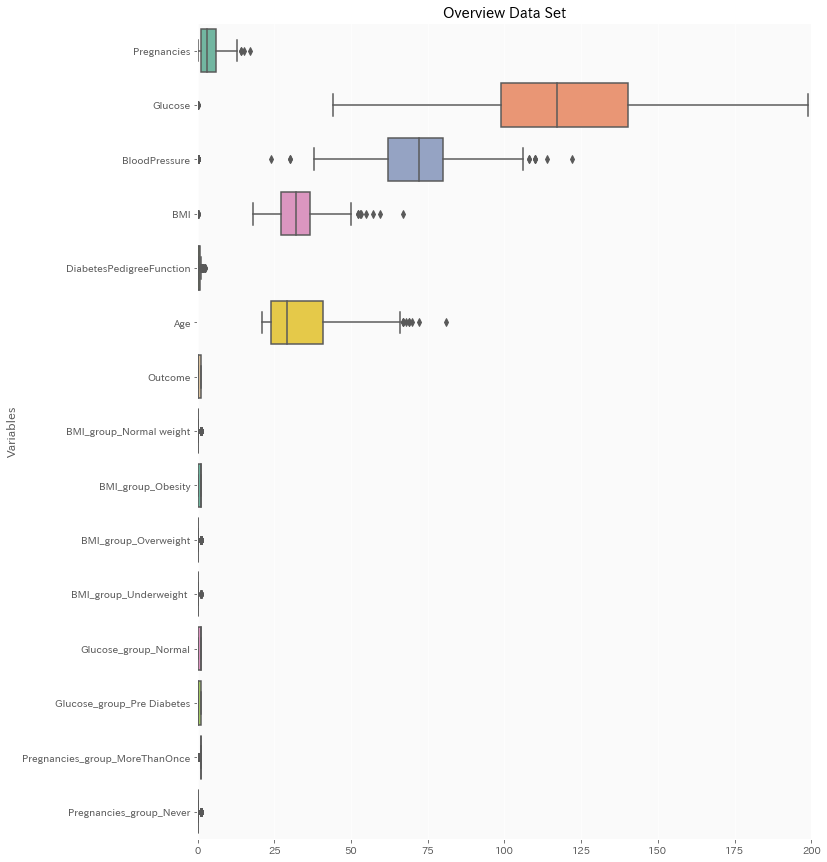

In [30]:
plt.style.use('ggplot')

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = d, 
  orient = 'h', 
  palette = 'Set2')

# Select features

In [170]:
d2.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never',
       'Outcome2'],
      dtype='object')

In [171]:
X = d2[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never']]
y = d2[["Outcome2"]]

In [172]:
len(X.columns)

14

# Split Train and Test

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model comparison

In [61]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('LSVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(("XGB",XGBClassifier()))
models.append(("ADB", AdaBoostClassifier()))

In [62]:
seed = 7
results = []
names = []
X_model_comparison = X_train
Y_model_comparison = y_train

In [63]:
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model, X_model_comparison, Y_model_comparison, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

LR: 0.750687 (0.044326)
KNN: 0.726388 (0.056636)
NB: 0.708831 (0.076649)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

SVC: 0.758884 (0.043677)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validati

LSVC: 0.752300 (0.041855)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was pa

RFC: 0.739344 (0.042023)
DTR: 0.719672 (0.038443)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

XGB: 0.754072 (0.026607)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

ADB: 0.753913 (0.054733)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [1]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

NameError: name 'plt' is not defined

# Feature imporntance check 

### Random Forest

In [65]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model =RandomForestClassifier(random_state=0).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [66]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist(),top=20)

Weight,Feature
0.1771 ± 0.0801,Glucose
0.0760 ± 0.0224,Age
0.0698 ± 0.0333,BMI
0.0646 ± 0.0214,DiabetesPedigreeFunction
0.0354 ± 0.0357,Pregnancies
0.0323 ± 0.0121,BloodPressure
0.0094 ± 0.0078,BMI_group_Obesity
0.0094 ± 0.0042,Glucose_group_Pre Diabetes
0.0031 ± 0.0051,BMI_group_Overweight
0.0010 ± 0.0042,Pregnancies_group_Never


### SVC

In [41]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model =SVC(random_state=0).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist(),top=20)

Weight,Feature
0.1115 ± 0.0504,Glucose
0.0437 ± 0.0382,Age
0.0365 ± 0.0161,DiabetesPedigreeFunction
0.0240 ± 0.0106,BMI
0.0115 ± 0.0167,Pregnancies
0.0083 ± 0.0156,BloodPressure
0.0021 ± 0.0051,BMI_group_Normal weight
0.0021 ± 0.0083,Glucose_group_Normal
0 ± 0.0000,Pregnancies_group_Never
0 ± 0.0000,Pregnancies_group_MoreThanOnce


### XGB

In [43]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model =XGBClassifier(random_state=0).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist(),top=20)

Weight,Feature
0.1906 ± 0.0580,Glucose
0.0823 ± 0.0305,Age
0.0667 ± 0.0305,BMI
0.0646 ± 0.0364,DiabetesPedigreeFunction
0.0188 ± 0.0141,BloodPressure
0.0021 ± 0.0106,Pregnancies
0 ± 0.0000,Pregnancies_group_Never
0 ± 0.0000,Pregnancies_group_MoreThanOnce
0 ± 0.0000,Glucose_group_Pre Diabetes
0 ± 0.0000,Glucose_group_Normal


### ADB

In [45]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model =AdaBoostClassifier(random_state=0).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist(),top=20)

Weight,Feature
0.1156 ± 0.0689,Glucose
0.0740 ± 0.0463,Age
0.0427 ± 0.0357,BMI
0.0198 ± 0.0283,DiabetesPedigreeFunction
0.0073 ± 0.0083,Pregnancies
0 ± 0.0000,Pregnancies_group_Never
0 ± 0.0000,Pregnancies_group_MoreThanOnce
0 ± 0.0000,Glucose_group_Pre Diabetes
0 ± 0.0000,Glucose_group_Normal
0 ± 0.0000,BMI_group_Underweight


### LR

In [47]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model =LogisticRegression(random_state=0).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist(),top=20)

Weight,Feature
0.1500 ± 0.0827,Glucose
0.0073 ± 0.0182,DiabetesPedigreeFunction
0.0010 ± 0.0078,Pregnancies_group_MoreThanOnce
0.0000 ± 0.0198,BMI_group_Obesity
0.0000 ± 0.0066,Pregnancies_group_Never
0 ± 0.0000,BMI_group_Underweight
-0.0010 ± 0.0078,BMI_group_Normal weight
-0.0010 ± 0.0179,BMI
-0.0010 ± 0.0042,BloodPressure
-0.0021 ± 0.0106,Glucose_group_Pre Diabetes


# Plot ROC and AUC

In [67]:
#Prep for LR

model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_pred_logistic = model_logistic.decision_function(X_test)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
#Prep for SVM

model_SVC = SVC()
model_SVC.fit(X_train, y_train)

y_pred_SVC = model_SVC.decision_function(X_test)

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C:\Users\yuka\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

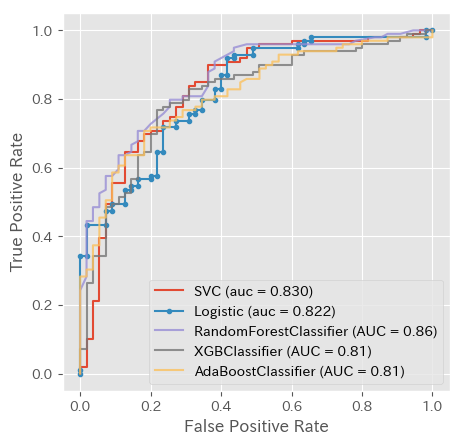

In [69]:
# LR
logistic_fpr, logistic_tpr, threshold = roc_curve(y_test, y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)

#SVM
svc_fpr, svc_tpr, threshold = roc_curve(y_test, y_pred_SVC)
auc_svc = auc(svc_fpr, svc_tpr)

# Plot Graph
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(svc_fpr, svc_tpr, linestyle='-', label='SVC (auc = %0.3f)' % auc_svc)
plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)

plt.legend()

#matplotlib
ax = plt.gca()

# prep for RFC
model_RFC = RandomForestClassifier()
model_RFC.fit(X_train, y_train)
RFC_display = plot_roc_curve(model_RFC, X_test, y_test, ax=ax, alpha=0.8)

#prep for XGB
model_XGB = XGBClassifier()
model_XGB.fit(X_train, y_train)
XGB_display = plot_roc_curve(model_XGB, X_test, y_test, ax=ax, alpha=0.8)

#Prep for ADB
model_ADB = AdaBoostClassifier()
model_ADB.fit(X_train, y_train)
ADB_display = plot_roc_curve(model_ADB, X_test, y_test, ax=ax, alpha=0.8)


plt.show()

* Random forest perfomes the best out of 5. 

# Ramdom Forest would perform the best for F1 score, tuning the model 

In [179]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [180]:
print("accuracy(train):{:.3f}".format(clf.score(X_train,y_train)))
print("accuracy(test):{:.3f}".format(clf.score(X_test,y_test)))

accuracy(train):1.000
accuracy(test):0.786


In [181]:
y_pred =clf.predict(X_test)

In [182]:
confusion_matrix_ =confusion_matrix(y_test,y_pred)
confusion_matrix_

array([[41, 14],
       [19, 80]], dtype=int64)

In [183]:
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.7857142857142857
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.71        55
         1.0       0.85      0.81      0.83        99

    accuracy                           0.79       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.79      0.79      0.79       154



In [184]:
def generate_model_report(y_test, y_pred):
    print("Accuracy = " , accuracy_score(y_test, y_pred))
    print("Precision = " ,precision_score(y_test, y_pred))
    print("Recall = " ,recall_score(y_test, y_pred))
    print("F1 Score = " ,f1_score(y_test, y_pred))
    pass

In [185]:
generate_model_report(y_test, y_pred)

Accuracy =  0.7857142857142857
Precision =  0.851063829787234
Recall =  0.8080808080808081
F1 Score =  0.8290155440414508


In [186]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

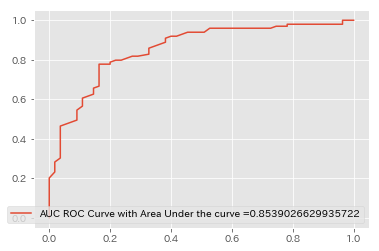

In [187]:
generate_auc_roc_curve(clf, X_test)

* The result above shows that this is a overfitting model.(100% for train data, 75% for test data)
* F1 socre of class 1 (Dibetes) is only 68% 

# Tuning Random forest by Gridsearch
* to check what "class_Weight" performs the best for "F1" score

In [79]:
weights_grid_rf= np.linspace(0.05, 0.95, 20)


gsc_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights_grid_rf]
    },
    scoring='f1',
    cv=5,
)

grid_result_rf = gsc_rf.fit(X_train, y_train)


C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was pa

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was pa

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was pa

C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\yuka\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was pa

In [80]:
print("Best parameters : %s" % grid_result_rf.best_params_)

Best parameters : {'class_weight': {0: 0.7605263157894736, 1: 0.2394736842105264}}


### Plot a graph (x = class weight, y = F1 score)

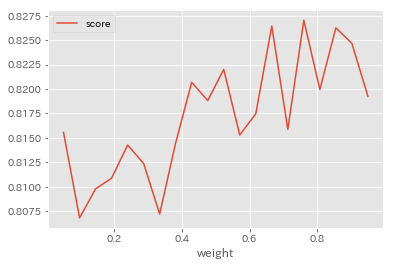

In [81]:
data_out_rf = pd.DataFrame({'score': grid_result_rf.cv_results_['mean_test_score'],
                       'weight': weights_grid_rf })
data_out_rf.plot(x='weight')

In [82]:
data_out_rf

,score,weight
0,0.815551,0.050000
1,0.806806,0.097368
2,0.809782,0.144737
3,0.810876,0.192105
4,0.814268,0.239474
5,0.812377,0.286842
6,0.807203,0.334211
7,0.814491,0.381579
8,0.820691,0.428947
9,0.818818,0.476316


### Try Gridseaerch turned class_weight

In [83]:
clf_grid_weight = RandomForestClassifier(**grid_result_rf.best_params_).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [84]:
y_pred = clf_grid_weight.predict(X_test)

In [85]:
pd.crosstab(y_pred , y_test["Outcome2"], rownames=['Predicted'], colnames=['Actual'])

Actual,0.0,1.0
Predicted,,
0.0,39,18
1.0,16,81


In [86]:
generate_model_report(y_test, y_pred)

Accuracy =  0.7792207792207793
Precision =  0.8350515463917526
Recall =  0.8181818181818182
F1 Score =  0.826530612244898


In [87]:
def generate_auc_roc_curve_grid(clf_grid_weight, X_test):
    y_pred_proba = clf_grid_weight.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

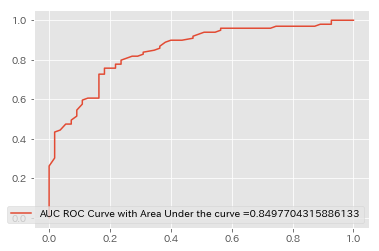

In [88]:
generate_auc_roc_curve_grid(clf_grid_weight, X_test)

# Tuning class_weight manually [1:2.2]

In [100]:
weights = {0:1 / (len(y[y == 0]) / len(y)),
           0:2.6/ (len(y[y == 1]) / len(y))}

In [121]:
clf_manual = RandomForestClassifier(class_weight = weights).fit(X_train, y_train)

C:\Users\yuka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [122]:
y_pred = clf_manual.predict(X_test)

In [123]:
pd.crosstab(y_pred , y_test["Outcome2"], rownames=['Predicted'], colnames=['Actual'])

Actual,0.0,1.0
Predicted,,
0.0,38,18
1.0,17,81


In [124]:
generate_model_report(y_test, y_pred)

Accuracy =  0.7727272727272727
Precision =  0.826530612244898
Recall =  0.8181818181818182
F1 Score =  0.8223350253807107


In [125]:
def generate_auc_roc_curve_manual(clf_manual, X_test):
    y_pred_proba = clf_manual.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

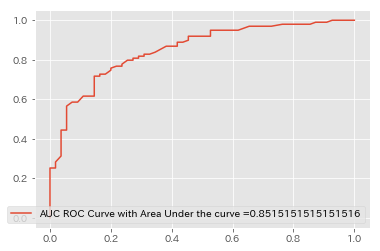

In [126]:
generate_auc_roc_curve_manual(clf_manual, X_test)

# Resampling oversampling: SMOTE
* 1. Split data, train and test (done above)
* 2. Count Diabetes and Non Diabetes in y_train 
* 3. 

In [174]:
print(len(y_train))
print(len(y_test))

614
154


In [175]:
# Count how many Diabetes and Non Diabetes in y_train(614) 

unique, count = np.unique(y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{0.0: 213, 1.0: 401}

In [176]:
# Apply SMOTE to increase Diabetes cases from 213 to 401 
# Diabetes is now 402 and Non Diabetes remails the same as 401. so total of X and y train is 802
# Ceate new train data (X_train_res, y_train_res)

sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [178]:
Y_train_dict_value_count

{0.0: 213, 1.0: 401}

In [177]:
print(len(X_train_res))
print(len(y_train_res))

802
802


In [129]:
unique, count = np.unique(y_train_res, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0.0: 401, 1.0: 401}

In [130]:
len(X_train_res)

802

In [131]:
X_train_res.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never
0,-0.547919,-1.237573,-0.197495,-0.339533,-0.507006,-1.041549,0,0,0,1,1,0,1,0
1,1.530847,-0.317862,0.794392,-0.615856,2.446670,1.425995,0,0,1,0,1,0,1,0
2,-0.844885,0.569003,-2.181268,-0.543139,0.550035,-0.956462,0,0,1,0,1,0,1,0
3,-1.141852,1.291634,-1.850639,-1.532084,-0.658012,2.702312,1,0,0,0,0,1,0,1
4,0.639947,0.404769,0.629077,2.001939,-0.706334,1.085644,0,1,0,0,1,0,1,0


In [132]:
len(y_train_res)

802

In [133]:
y_train_res.head()

,Outcome2
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


# Train a Model with Resumpling train and test data!!!!
# Prediction will be used for " X_test" and "y_test" !!!! 

In [85]:
clf.fit(X_train_res, y_train_res)

C:\Users\yuka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [86]:
y_pred = clf.predict(X_test)

In [87]:
pd.crosstab(y_pred , y_test["Outcome2"], rownames=['Predicted'], colnames=['Actual'])

Actual,0.0,1.0
Predicted,,
0.0,44,24
1.0,11,75


In [88]:
generate_model_report(y_test, y_pred)

Accuracy =  0.7727272727272727
Precision =  0.872093023255814
Recall =  0.7575757575757576
F1 Score =  0.8108108108108109


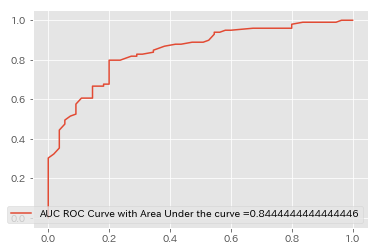

In [89]:
generate_auc_roc_curve(clf, X_test)

In [90]:
y_pred = clf_grid_weight.predict(X_test)

In [91]:
pd.crosstab(y_pred , y_test["Outcome2"], rownames=['Predicted'], colnames=['Actual'])

Actual,0.0,1.0
Predicted,,
0.0,37,18
1.0,18,81


In [92]:
generate_model_report(y_test, y_pred)

Accuracy =  0.7662337662337663
Precision =  0.8181818181818182
Recall =  0.8181818181818182
F1 Score =  0.8181818181818182


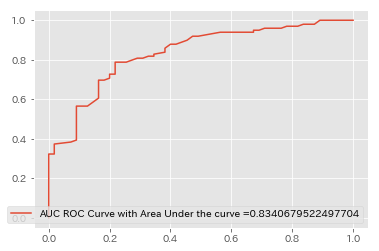

In [93]:
generate_auc_roc_curve(clf_grid_weight, X_test)

In [94]:
y_pred = clf_manual.predict(X_test)

In [95]:
pd.crosstab(y_pred , y_test["Outcome2"], rownames=['Predicted'], colnames=['Actual'])

Actual,0.0,1.0
Predicted,,
0.0,40,17
1.0,15,82


In [96]:
generate_model_report(y_test, y_pred)

Accuracy =  0.7922077922077922
Precision =  0.845360824742268
Recall =  0.8282828282828283
F1 Score =  0.836734693877551


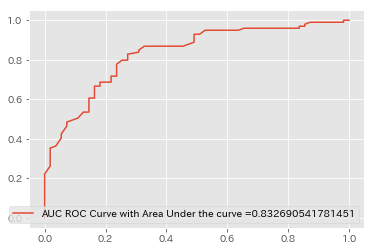

In [97]:
generate_auc_roc_curve_manual(clf_manual, X_test)

# Random undersampling

In [98]:
# Count how many minority class are. (count Diabete observations) 

minority_class_len = len(d2[d2["Outcome2"] == 0])
print(minority_class_len)

268


In [99]:
# Get all of Non Dibetes' observation indices

majority_class_indices = d2[d2["Outcome2"] == 1].index
print(majority_class_indices)

Int64Index([  1,   3,   5,   7,  10,  12,  18,  20,  21,  27,
            ...
            751, 752, 756, 758, 760, 762, 763, 764, 765, 767],
           dtype='int64', length=500)


In [100]:
len(majority_class_indices)

500

In [101]:
# Choose 268 Non Diabetes' observations randomly. (the same amount of the nmber of Diabetes observations)

random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

268


In [102]:
minority_class_indices = d2[d2["Outcome2"] == 0].index
print(minority_class_indices)

Int64Index([  0,   2,   4,   6,   8,   9,  11,  13,  14,  15,
            ...
            748, 749, 750, 753, 754, 755, 757, 759, 761, 766],
           dtype='int64', length=268)


In [103]:
# Putting 2 groups of indices together = Diabetes 268 + reduced Non Diabetes 268 

under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])
len(under_sample_indices)

536

In [104]:
under_sample_indices

array([  0,   2,   4,   6,   8,   9,  11,  13,  14,  15,  16,  17,  19,
        22,  23,  24,  25,  26,  31,  37,  38,  39,  43,  45,  48,  53,
        56,  61,  64,  66,  70,  72,  78,  84,  88,  93,  99, 100, 109,
       110, 111, 114, 115, 116, 120, 124, 125, 128, 129, 130, 131, 132,
       143, 152, 154, 155, 159, 164, 165, 170, 171, 175, 177, 179, 185,
       186, 187, 188, 189, 192, 193, 195, 197, 198, 199, 206, 207, 209,
       213, 214, 215, 216, 218, 219, 220, 221, 227, 230, 231, 235, 236,
       237, 238, 242, 243, 245, 254, 255, 259, 261, 264, 266, 269, 270,
       276, 280, 283, 284, 287, 291, 292, 293, 296, 298, 300, 301, 303,
       306, 308, 309, 312, 314, 317, 319, 321, 322, 323, 326, 328, 332,
       337, 338, 339, 349, 355, 356, 357, 359, 360, 363, 366, 369, 370,
       375, 378, 386, 387, 388, 391, 394, 397, 399, 400, 402, 404, 406,
       408, 409, 414, 415, 417, 419, 424, 425, 427, 429, 435, 440, 443,
       444, 445, 448, 451, 455, 458, 468, 476, 480, 484, 485, 49

In [105]:
# Making DataFrame of 268 Diabetes + 268 reduced Non Diabetes

under_sample = d2.loc[under_sample_indices]
under_sample

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,BMI_group_Normal weight,BMI_group_Obesity,BMI_group_Overweight,BMI_group_Underweight,Glucose_group_Normal,Glucose_group_Pre Diabetes,Pregnancies_group_MoreThanOnce,Pregnancies_group_Never,Outcome2
0,0.639947,0.864625,-0.032180,0.169483,0.468492,1.425995,0,1,0,0,0,1,1,0,0.0
2,1.233880,2.014265,-0.693438,-1.328478,0.604397,-0.105584,1,0,0,0,0,1,1,0,0.0
4,-1.141852,0.503310,-2.677212,1.551096,5.484909,-0.020496,0,1,0,0,1,0,0,1,0.0
6,-0.250952,-1.434655,-1.850639,-0.208643,-0.676133,-0.616111,0,1,0,0,1,0,1,0,0.0
8,-0.547919,2.474120,-0.197495,-0.281360,-0.947944,1.681259,0,1,0,0,0,1,1,0,0.0
9,1.233880,0.109147,1.951593,0.271286,-0.724455,1.766346,0,0,0,1,1,0,1,0,0.0
11,1.827813,1.521562,0.133134,0.809388,0.196681,0.064591,0,1,0,0,0,1,1,0,0.0
13,-0.844885,2.211346,-1.024067,-0.339533,-0.223115,2.191785,0,1,0,0,0,1,1,0,0.0
14,0.342981,1.455868,-0.032180,-0.964895,0.347687,1.511083,0,0,1,0,0,1,1,0,0.0
15,0.936914,-0.712024,0.174463,-0.354076,0.036615,-0.105584,0,1,0,0,1,0,1,0,0.0


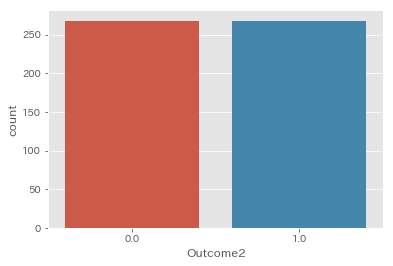

In [106]:
sns.countplot(x="Outcome2", data=under_sample)

In [107]:
under_sample.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never',
       'Outcome2'],
      dtype='object')

In [167]:
X_sample = under_sample[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'BMI_group_Normal weight',
       'BMI_group_Obesity', 'BMI_group_Overweight', 'BMI_group_Underweight ',
       'Glucose_group_Normal', 'Glucose_group_Pre Diabetes',
       'Pregnancies_group_MoreThanOnce', 'Pregnancies_group_Never']]
y_sample = under_sample["Outcome2"]


In [168]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [169]:
clf_grid_weight.fit(X_train_s, y_train_s)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.95, 1: 0.050000000000000044},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
y_pred_s = clf_grid_weight.predict(X_test_s)

In [172]:
confusion_matrix_ =confusion_matrix(y_test_s,y_pred_s)
confusion_matrix_

array([[42, 17],
       [14, 35]], dtype=int64)

In [173]:
print(metrics.accuracy_score(y_test_s, y_pred_s))
print(metrics.classification_report(y_test_s, y_pred_s))

0.7129629629629629
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73        59
         1.0       0.67      0.71      0.69        49

    accuracy                           0.71       108
   macro avg       0.71      0.71      0.71       108
weighted avg       0.72      0.71      0.71       108



In [162]:
def generate_model_report_us(y_test_s, y_pred_s):
    print("Accuracy = " , accuracy_score(y_test_s, y_pred_s))
    print("Precision = " ,precision_score(y_test_s, y_pred_s))
    print("Recall = " ,recall_score(y_test_s, y_pred_s))
    print("F1 Score = " ,f1_score(y_test_s, y_pred_s))
    pass

In [163]:
generate_model_report_us(y_test_s, y_pred_s)

Accuracy =  0.7222222222222222
Precision =  0.6792452830188679
Recall =  0.7346938775510204
F1 Score =  0.7058823529411764


In [147]:
def generate_auc_roc_curve_us_weight(clf_grid_weight, X_test_s):
    y_pred_proba_s = clf_grid_weight.predict_proba(X_test_s)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_s,  y_pred_proba_s)
    auc = roc_auc_score(y_test_s, y_pred_proba_s)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

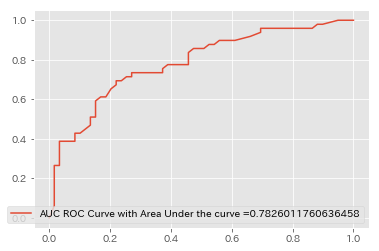

In [148]:
generate_auc_roc_curve_us_grid(clf_grid_weight, X_test_s)

In [149]:
clf_manual.fit(X_train_s,y_train_s)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 2.4},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [150]:
y_pred_s = clf_manual.predict(X_test_s)

In [155]:
pd.crosstab(y_test_s[["Outcome2"]], y_pred_s, rownames=['Predicted'], colnames=['Actual'])

Actual,0.0,1.0
Predicted,,
0.0,46,13
1.0,16,33


In [156]:
print(f1_score(y_test_s, y_pred_s))

0.6947368421052631


In [152]:
generate_model_report_us(y_test_s, y_pred_s)

Accuracy =  0.7314814814814815
Precision =  0.717391304347826
Recall =  0.673469387755102
F1 Score =  0.6947368421052631


In [127]:
def generate_auc_roc_curve_us_manual(clf_manual, X_test_s):
    y_pred_proba_s = clf_manual.predict_proba(X_test_s)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_s,  y_pred_proba_s)
    auc = roc_auc_score(y_test_s, y_pred_proba_s)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

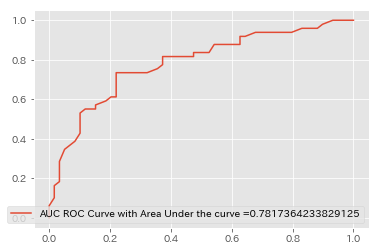

In [128]:
generate_auc_roc_curve_us_manual(clf_manual, X_test_s)

# FN and FP 

In [188]:
FN_FP = pd.DataFrame({'Actual': y_test.iloc[:,0], 'Predicted': y_pred})
FN_FP.head(10)

,Actual,Predicted
668,1.0,1.0
324,1.0,1.0
624,1.0,1.0
690,1.0,1.0
473,1.0,1.0
204,1.0,1.0
97,1.0,1.0
336,1.0,0.0
568,1.0,0.0
148,1.0,0.0


In [189]:
indices = []
for i in range(len(y_test)) :
    if y_test.iloc[i]["Outcome2"] != y_pred[i]:
        indices.append(i)

print(indices)

[7, 8, 9, 10, 11, 12, 13, 15, 24, 28, 34, 37, 42, 43, 49, 53, 63, 65, 70, 73, 81, 83, 95, 96, 100, 103, 108, 111, 129, 133, 136, 143, 146]


In [191]:
wrong_predictions = FN_FP.iloc[indices,:]
wrong_predictions

,Actual,Predicted
336,1.0,0.0
568,1.0,0.0
148,1.0,0.0
667,0.0,1.0
212,1.0,0.0
199,0.0,1.0
265,1.0,0.0
356,0.0,1.0
281,1.0,0.0
328,0.0,1.0


In [136]:
FN_FP_s = pd.DataFrame({'Actual': y_test_s, 'Predicted': y_pred_s})
FN_FP_s.head(10)

,Actual,Predicted
306,0.0,0.0
339,0.0,0.0
404,0.0,0.0
709,0.0,1.0
220,0.0,0.0
50,1.0,1.0
11,0.0,0.0
563,1.0,1.0
502,0.0,0.0
155,0.0,0.0


* screenshot of F1 and AUC chart , add presentation
* fix problems of resampling results